<a href="https://colab.research.google.com/github/flydragon2018/Analytics_Vidhya/blob/master/handwriting_recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip -q /content/drive/"My Drive"/handwriting/handWriting.zip 

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [4]:
pwd

'/content'

In [5]:
ls

drive/  hw_model.h5  sample_data/  test/  train/  train.csv


In [6]:
train = pd.read_csv('train.csv')
#valid=train.sample(frac=0.1) 

maxlabel=int(train["label"].str.len().max())
print(maxlabel)

34


In [7]:
train.head()

,filename,label
0,0,BALTHAZAR
1,1,SIMON
2,2,BENES
3,3,LA LOVE
4,4,DAPHNE


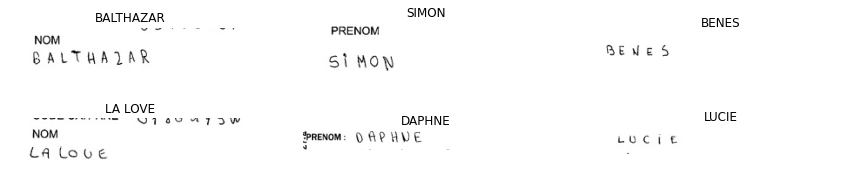

In [8]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train/'+str(i)+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
print("Number of NaNs in train set      : ", train['label'].isnull().sum())
 


Number of NaNs in train set      :  643


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372331 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  372331 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.7+ MB


In [11]:
train.dropna(axis=0, inplace=True)
 

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371688 entries, 0 to 372330
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  371688 non-null  int64 
 1   label     371688 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


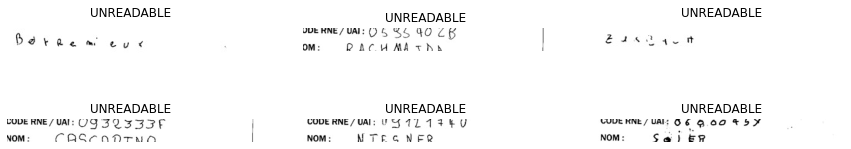

In [13]:
unreadable = train[train['label'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir =img_dir = 'train/'+str(unreadable.loc[i,"filename"])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [14]:
train = train[train['label'] != 'UNREADABLE']
 

In [15]:
train['label'] = train['label'].str.upper()
 

In [16]:
train.reset_index(inplace = True, drop=True) 
 

In [17]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [18]:
!nvidia-smi

Mon Aug 31 03:16:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
train_size = 40000
valid_size= 4000

print(train_size,valid_size)

40000 4000


In [20]:
#first round 
start_i=0
#start_i=train_size

In [21]:
train_x = []

for i in range(start_i,(start_i+train_size),1):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [22]:
##valid_x =train_x[0:valid_size]

In [23]:

valid_x =[]

for i in range(start_i,start_i+valid_size,1):
    img_dir = 'train/'+str(train.loc[i, 'filename'])+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)


In [24]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [25]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
 
max_str_len = int(maxlabel) # max length of input labels 34
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [26]:
name = 'DRAGON'
print(name, '\n',label_to_num(name))

DRAGON 
 [ 3 17  0  6 14 13]


In [27]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(start_i,(start_i+train_size),1):
    train_label_len[i] = len(str(train.loc[i, 'label']))
    train_y[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))    


In [28]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(start_i,start_i+valid_size,1):
    valid_label_len[i] = len(str(train.loc[i, 'label']))
    valid_y[i, 0:len(str(train.loc[i, 'label']))]= label_to_num(str(train.loc[i, 'label']))  

In [29]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

In [30]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [31]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [32]:
#!cp /content/drive/"My Drive"/handwriting/hw_model.h5 .

In [33]:
#from keras.models import load_model
#model_final = load_model("hw_model.h5")

In [34]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

In [35]:
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, \
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),epochs=360, batch_size=128)

Epoch 1/360
313/313 [==============================] - 60s 193ms/step - loss: 25.6141 - accuracy: 0.0000e+00 - val_loss: 20.3587 - val_accuracy: 0.0000e+00
Epoch 2/360
313/313 [==============================] - 57s 184ms/step - loss: 20.0591 - accuracy: 0.0000e+00 - val_loss: 19.9408 - val_accuracy: 0.0000e+00
Epoch 3/360
313/313 [==============================] - 58s 184ms/step - loss: 19.6233 - accuracy: 0.0000e+00 - val_loss: 19.4012 - val_accuracy: 0.0000e+00
Epoch 4/360
313/313 [==============================] - 57s 183ms/step - loss: 19.0877 - accuracy: 0.0000e+00 - val_loss: 18.7606 - val_accuracy: 0.0000e+00
Epoch 5/360
313/313 [==============================] - 57s 183ms/step - loss: 18.2876 - accuracy: 0.0000e+00 - val_loss: 18.0101 - val_accuracy: 0.0000e+00
Epoch 6/360
313/313 [==============================] - 57s 183ms/step - loss: 17.0606 - accuracy: 0.0000e+00 - val_loss: 17.3535 - val_accuracy: 0.0000e+00
Epoch 7/360
313/313 [==============================] - 57s 183ms

In [35]:
'''

# Custom Metric (without external parameters)
def metric_no_params(yTrue,yPred):
  return tf.keras.metrics.sparse_categorical_accuracy(yTrue, yPred)

# Create a basic model instance
model = create_model()

# Compile the model
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy',metric_no_params]) 

# define history callback (you can use it to access some parameters under it)
history = model.fit(x_train, y_train, epochs = Epochs, verbose=1,batch_size=128)

loss, acc, acc_spa  = model.evaluate(x_test, y_test, verbose=10) 
print("Original model, accuracy: {:5.2f}%".format(100*acc))

# Loading the saved model and testing the performance (tf format)
loaded_model_tf = tf.keras.models.load_model('MyModel_tf',custom_objects={'MyLoss_layer':MyLoss_layer()}) # 

# Evaluate the loaded model after loading weights from tf 
loss, acc_tf = loaded_model_tf.evaluate(x_test, y_test, verbose=1)
print("Loaded model (tf), loss:{:5.2f} and accuracy: {:5.2f}% ".format(loss, 100*acc_tf))

# Loading the saved model and testing the performance (h5 format)
loaded_model_h5 = tf.keras.models.load_model('MyModel_h5', custom_objects={'metric_no_params':metric_no_params})


# Evaluate the loaded model after loading weights from h5 
loss, acc_h5, acc_h5_cust = loaded_model_h5.evaluate(x_test, y_test, verbose=1)
print("Loaded model (h5), accuracy: {:5.2f}%".format(100*acc_h5))

'''

In [ ]:
'''
# Define ModelCheckpoint callback
checkpoint_path = "best_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, monitor='val_acc', verbose=1, save_weights_only=False,
   # Save weights, every epoch.
   # save_freq='epoch',
   mode='auto',save_best_only=True)

# Train the model
model.fit(x_train, y_train, epochs=Epochs,validation_data=(x_test, y_test), callbacks=[checkpoint_callback])
'''

In [35]:
# Saving entire model in tf format
model_final.save("MyModel360_tf",save_format='tf')

# Saving entire model in h5 format
model_final.save("MyModel360_h5",save_format='h5')

In [36]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [38]:
y_true = train.loc[start_i:start_i+valid_size,'label']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))


Correct characters predicted : 85.04%
Correct words predicted      : 82.65%


In [39]:
model_final.save('hw360_v2_model.h5')

In [40]:
!cp *.h5  /content/drive/"My Drive"/handwriting

In [41]:
test = os.listdir('test')
testnum=len(test)

sub=[]
for i in range(testnum):
    
    img_dir = 'test/'+test[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
       
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    #print(decoded)
    sub.append([test[i][:-4],num_to_label(decoded[0])])
    print(i,test[i][:-4],num_to_label(decoded[0]) )
    
    #if i==10:
    #  break

df=pd.DataFrame(sub)
df.to_csv("hw360_v2_sub.csv",index=None,header=None)

Streaming output truncated to the last 5000 lines.
36371 25130 FAUGUSTIN
36372 23260 SAUNIEA
36373 13886 GJRY
36374 15825 JACQUES
36375 35774 SVWALLAROWILT
36376 23026 FENZO
36377 25977 JMAGUET
36378 40194 DAVARRALECLERC
36379 27792 GELINA
36380 11605 LUCIE
36381 453 ANTOINE
36382 21558 GAUTIER
36383 9397 INES
36384 15928 CHAALES
36385 14102 DI MAIO
36386 3977 GARNAUD
36387 3683 DMINET
36388 1925 METREAU
36389 28576 QOCEANE
36390 9123 KAREN
36391 36915 FALIZEE
36392 1328 ZOE
36393 6981 KHANIFI
36394 9331 CHEMACHI
36395 32734 BLACHE
36396 34301 CHARLEMONT
36397 404 DE VANDEL
36398 12850 STHIAM
36399 8450 MARIE
36400 38702 THOMASSIN
36401 11859 SOCEANE
36402 29673 MNIMELLE
36403 29346 LE BESCON
36404 2187 DECRA
36405 14544 LIGONECHE
36406 5374 HELISENDE
36407 27283 LOIC
36408 18977 CEMELINE
36409 28652 APOLLINE
36410 38857 DOUIS
36411 14626 DEMEI
36412 24083 DELANOG
36413 28207 PETRONE
36414 37664 TOUAREF
36415 4942 HNOEMIE
36416 2929 DEUA
36417 26547 GEMILIE
36418 14661 BGUILLALME
36419

In [43]:
!cp *.csv /content/drive/"My Drive"/handwriting